# Economie du stockage

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sn 
%matplotlib inline 
plt.style.use('ggplot')

In [3]:
prices = pd.read_csv('../data/Day-ahead_Prices_FR_2020.csv',sep=";",encoding='utf-8',decimal=',')
prices = prices.rename(columns={"MTU (CET)":'Time','Day-ahead Price [EUR/MWh]':'Price'})
prices['Price'] = prices['Price'].str.replace(',','.')

In [4]:
df = prices.iloc[:744].copy() #31*24 = 744
# Preprocessing pour avoir un df clean
df['Day'] = [i//24 for i in range(len(df))]
df['BeginTime']  = pd.to_datetime([t.split('-')[0] for t in df['Time']])
df = df[['Day','BeginTime','Price']]
df['Price'] = pd.to_numeric(df['Price'])

In [5]:
df.head(1)

,Day,BeginTime,Price
0,0,2020-01-01,41.88


In [6]:
df.tail(2)

,Day,BeginTime,Price
742,30,2020-01-31 22:00:00,28.74
743,30,2020-01-31 23:00:00,24.12


No handles with labels found to put in legend.


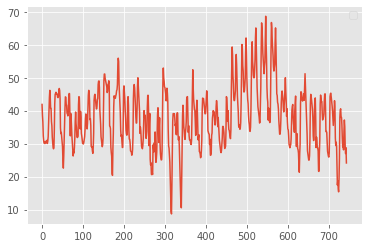

In [7]:
plt.plot(df['Price'])
plt.legend()
plt.show()

# Charge & Décharge

Alternance de cycle de charge et de décharge : 
(0,1,0,1)
0 = charge
1 = décharge 

> Connaissant les prix fixés à l'avance nous allons donc charger notre batterie sur le réseau quand le prix est le plus faible et le vendre ensuite quand le prix est le plus elevé

### Il faut trouver pour chaque les deux prix qui sont les plus compétitifs. Le prix le plus faible avant le prix le plus elevé.

## Créer une matrice : 
colonnes : jour & lignes : min & max 
rectangle, avec un indice pour vérifier que le min précède le top

In [8]:
def find_min_max(df,i=0):
    """Permet de trouver le min et le max de la fonction prix en garantissant que le minimum précède le maximum"""
    day = df[df.Day==i].reset_index(drop=True)
    id_min=1
    id_max =0
    while id_min > id_max:
        id_min = day['Price'].idxmin()
        id_max = day['Price'].idxmax()
        max_price = max(day.Price)
        min_price = min(day.Price)
        # Si le id_min apparait après le max, on ne va pas le considérer
        # Le maximum de prix ne peut pas non plus être au début du df 
        if id_max ==0:
            day = day.drop(id_max)
        else:
            day = day.drop(id_min)
    return(id_min,id_max,min_price,max_price)

In [9]:
def create_price_matrix(df):
    mat = np.zeros((max(df.Day)+1,2,2))
    for i in range(max(df.Day)+1):
        # Extraire les prix de la journée max 
        id_min,id_max,min_price,max_price = find_min_max(df,i=i)
        mat[i][0][0] = min_price
        mat[i][1][0] = max_price
        mat[i][0][1] = id_min+min(df[df.Day==i].index)
        mat[i][1][1] = id_max+min(df[df.Day==i].index)
    return(mat)

In [10]:
def calc_profit(df,mat,pho=0.8):
    daily_profit = []
    trade = []
    for i in range(max(df.Day)+1):
        profit = pho*mat[i][1][0]-mat[i][0][0]
        if profit <=0 : 
            daily_profit.append(0)
            trade.append(0)
        else: 
            daily_profit.append(profit)
            trade.append(1)
    return(daily_profit,trade)

In [11]:
def plot_min_max(df,i,rho = 1):
    plt.figure(figsize=(7,7))
    df[df.Day==i]['Price'].reset_index(drop=True).plot()
    # Find min & max 
    id_min,id_max,min_price,max_price = find_min_max(df,i)
    # Figure size
    plt.xlabel('Heures')
    plt.ylabel('Prix [EUR/MWh]')
    plt.ylim(min_price-7,max_price+10)
    plt.xlim(-1,26)
    # Different plot depending on profit 
    profit = round(rho*max_price-min_price,2)
    if profit <= 0:
        # No sell - Sell price below buy price 
        plt.text(id_min+0.5,min_price-3,r'$\bf{Charge :}$'+f'(Min)\n{id_min} h - {min_price}€')
        plt.text(id_max+0.5,max_price+3,r'$\bf{Max :}$'+f'{id_max} h - {max_price}€\n'+r'$\bf{\rho\: trop\: faible}$'+f'\n {round(max_price*rho,2)}€ < {min_price}€')
        profit = 0 
        # Minimum
        plt.arrow(id_min,min_price-2,0,1,head_width =0.5,width=0.25,ec="green")
    # Maximum
        plt.arrow(id_max,max_price+2,0,-1,head_width =0.5,width=0.25,ec="blue")
        plt.text(0,max_price-2,'PAS DE DEAL!',fontsize=12,bbox=dict(facecolor='r', alpha=0.5))

        
    else : 
        plt.text(id_min+0.5,min_price-3,r'$\bf{Charge :}$'+f'(Min)\n{id_min} h - {min_price}€')
        plt.arrow(id_min,min_price-5,0,4,head_width =0.5,width=0.25,ec="green")
        # Maximum
        plt.arrow(id_max,max_price+5,0,-4,head_width =0.5,width=0.25,ec="blue")
        plt.text(id_max+0.5,max_price+3,r'$\bf{Décharge :}$'+f'(Max)\n{id_max} h - {max_price}€\nVente : {round(max_price*rho,2)}€ > {min_price}€')
        plt.text(0,max_price-2,'ACHAT/REVENTE !',fontsize=12,bbox=dict(facecolor='g', alpha=0.5))

    plt.legend(loc='upper left')
    plt.title(r'$\mathbf{\rho}$'+f'={rho} | {i+1}/01 - {profit} € bénéfices')
    plt.show()


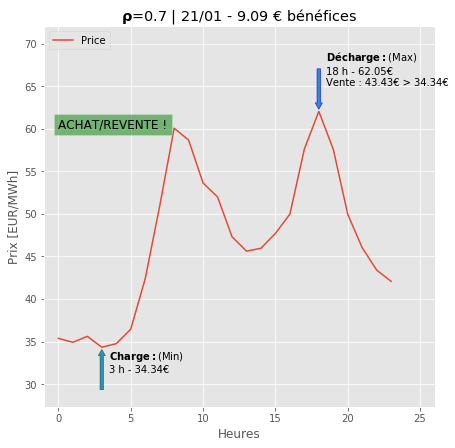

In [12]:
plot_min_max(df,20,0.7)

# Visualiser le profit en fonction de rho

In [13]:
import plotly.graph_objects as go
def visualize_profit(df,pho=np.linspace(0.5,1,4)):
    mat = create_price_matrix(df)
    dailypnl = []
    trades = []
    total = []
    for p in pho : 
        dailypnl.append(calc_profit(df,mat,pho=p)[0])
        total.append(round(sum(calc_profit(df,mat,pho=p)[0]),0))
        trades.append(calc_profit(df,mat,pho=p)[1])
        plt.plot(calc_profit(df,mat,pho=p)[0],label=f'Pho {round(p,2)}')
    plt.title('Profits réalisés en fonction du rendement')
    plt.xlabel('Jours')
    plt.ylabel('€')
    plt.legend(loc='upper left')
    plt.show()
    recap = pd.DataFrame()
    recap[r'$\rho$'] = [round(p,2) for p in pho]
    for i in range(31):
        profits = []
        for j in range(len(pho)):
            profits.append(round(dailypnl[j][i],1))
        recap[f'J{i+1}'] = profits
    recap['Total'] = total
    create_table(recap)
def create_table(recap):
    colors = ['rgb(245, 245, 245)']
    for i in range(31):    
        colors.append([pick_color(val) for val in recap[f'J{i+1}']])
    colors.append('rgb(245, 245, 245)')
    fig = go.Figure(data=[go.Table(header=dict(values=recap.columns),
                 cells=dict(values =[recap[col] for col in recap.columns],fill = dict(color=colors)))],
                   )
    fig.update_layout(height=290,title_text ='Profits journaliers (€) en fonction du rendement')
    fig.show()
def pick_color(val):
    if 0>=val:
        col = 'rgba(250,0, 0, 0.8)'
    elif val <=15:
        col = 'rgba(250, 250, 0, 0.8)'
    else :
        col = 'rgba(0, 250, 0, 0.8)'
    return(col)


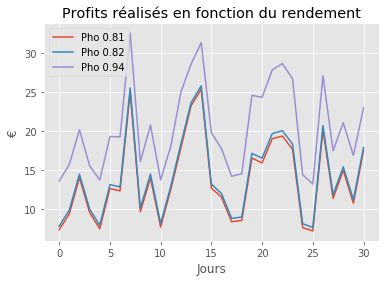

In [46]:
visualize_profit(df,pho=[0.81,0.82,0.945])

### Storage technologies

In [17]:
storage = pd.read_excel('../data/storage_technologies.xlsx')

In [20]:
storage.head()

,Type,Technology,Year,Installation-cost-worst,Installation-cost-reference,Installation-cost-best,Power density-worst,Power density-best,Rho,Self-discharge-worst,Self-discharge-reference,Self-discharge-best
0,Flow,VRFB,2016,1050,347,315,1,2,70.0,1.0,0.15,0.00
1,NaN,NaN,2030,360,119,108,1,2,78.0,1.0,0.15,0.00
2,NaN,ZBFB,2016,1680,900,525,1,25,70.0,33.6,15.00,8.00
3,NaN,NaN,2030,576,309,180,1,25,78.0,33.6,15.00,8.00
4,High- temperature,NaNiCl,2016,488,399,315,150,270,84.0,15.0,5.00,0.05


In [23]:
storage["Type"] = storage['Type'].fillna(method="ffill")
storage["Technology"] = storage['Technology'].fillna(method="ffill")

In [34]:
storage.head()

In [44]:
df1 = storage.groupby(["Year","Type"]).mean().astype(float)[['Installation-cost-reference','Rho']].sort_values(by=["Year",'Rho']).round(2)
df1['Rho/Cost'] = df1['Rho']/df1['Installation-cost-reference']
df1 = df1.sort_values(by=['Year','Rho/Cost'],ascending=[True,False])

In [42]:
from IPython.display import display

In [45]:
display(df1)

Installation-cost-reference    Rho  Rho/Cost
Year Type                                                           
2016 Lead-acid                               205.00  81.00  0.395122
     High- temperature                       383.50  82.00  0.213820
     Li-ion                                  600.00  94.50  0.157500
     Flow                                    623.50  70.00  0.112269
     Mechanical                             1024.67  74.67  0.072872
2030 Lead-acid                               103.00  84.00  0.815534
     High- temperature                       161.50  86.00  0.532508
     Li-ion                                  253.50  96.50  0.380671
     Flow                                    214.00  78.00  0.364486
     Mechanical                              674.67  78.33  0.116101